In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl

import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)
import os

In [28]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'TEST_m11'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 4,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'twice_Polar_NLLH',
        'zenith': True,
        'id': wandb.util.generate_id()[:4],
        'eps': 0,
        'lr': 8e-2,
        'filename': 'muon_500k_scaled2.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'charge_log10, time, pulse_width, SRTInIcePulses, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith',
        'TrTV': (0.1,0.99,1)#(0.025,0.995,1)
       }

In [12]:
# centers = pd.DataFrame({'charge_log10': [-0.033858],
#                         'dom_time': [10700.0],
#                         'dom_x': [0],
#                         'dom_y': [0],
#                         'dom_z': [0]})
# scalers = pd.DataFrame({'charge_log10': [0.274158],
#                         'dom_time': [2699.0],
#                         'dom_x': [300],
#                         'dom_y': [300],
#                         'dom_z': [300]})
# centers = centers[args['features'].split(', ')].values
# scalers = scalers[args['features'].split(', ')].values

# def x_transform(df):
#     df = (df - centers)/scalers
#     return torch.tensor(df.values)

# def y_transform(df):
#     return torch.tensor(df.values)

In [33]:
# filepath = os.path.join(path,'raw_data/dev_level7_mu_e_tau_oscweight_000/data')
filepath = os.path.join(path,'raw_data')


tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\transformers.pkl')
# tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\dev_level7_mu_e_tau_oscweight_000\data\meta\transformers.pkl')
event_nos = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\event_nos_500k_muon_set1.pkl').values.reshape(-1)

def x_transform(df):
    pos = ['dom_x','dom_y','dom_z']
    for col in pos:
        df[col] = tf['features'][col].inverse_transform(df[[col]])
    df[pos] /= 300
    return torch.tensor(df.values)
def y_transform(df):
    for col in df.columns:
        df[col] = tf['truth'][col].inverse_transform(df[[col]])
    return torch.tensor(df.values)

# #@torch.jit.script
# def x_transform(df):
#     df['charge_log10'] = (df['charge_log10'] - charge_center)/charge_scale
#     df['dom_time'] = (df['dom_time'] - time_center)/time_scale
#     df[['dom_x','dom_y','dom_z']] /= 300
#     return torch.tensor(df.values)
# #@torch.jit.script
# def y_transform(df):
#     return torch.tensor(df.values)



dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
#                                event_nos = event_nos,
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = True)

In [34]:
train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=512, num_workers=0) #~0.6sec loading time pr. batch

In [61]:
# start = time.time()
# for dat in train_loader:
#     print(time.time() - start)
#     start = time.time()

In [35]:
import Model_Loaders.Model_9 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net()

device = torch.device('cuda')

model.to(device);

Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [36]:
start = time.time() 
for dat in train_loader:
    dat.to(device)
    print('loading \t:', time.time() - start)
    
    start = time.time() 
    out = model(dat)
    print('evaluation \t:', time.time() - start)
    
    start = time.time() 
    output, cov = model.output_post_processor( out )
    loss = model.crit(output, cov, model.y_post_processor(dat.y))
    
    
    loss.backward
    print('backward \t:', time.time() - start)
    start = time.time() 
    
#     model.training_step(dat,None)
    

loading 	: 0.40918970108032227
evaluation 	: 1.0610003471374512
backward 	: 0.004995822906494141
loading 	: 0.42400145530700684
evaluation 	: 1.1240005493164062
backward 	: 0.0029993057250976562
loading 	: 0.4479994773864746
evaluation 	: 0.8770039081573486
backward 	: 0.003998279571533203
loading 	: 0.3729991912841797
evaluation 	: 0.8790016174316406
backward 	: 0.003998279571533203
loading 	: 0.38100504875183105
evaluation 	: 0.9189941883087158
backward 	: 0.004000425338745117
loading 	: 0.36800074577331543
evaluation 	: 0.9229977130889893
backward 	: 0.00400090217590332
loading 	: 0.34200096130371094
evaluation 	: 0.8719978332519531
backward 	: 0.0030002593994140625
loading 	: 0.3620016574859619
evaluation 	: 0.8180046081542969
backward 	: 0.004998683929443359
loading 	: 0.3549971580505371


KeyboardInterrupt: 

In [67]:
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,
#                                           ckpt = run_name + '_latest.ckpt'
                                          )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores



   | Name                | Type       | Params
----------------------------------------------------
0  | act                 | SiLU       | 0     
1  | x_encoder           | Linear     | 3.6 K 
2  | CoC_encoder         | Linear     | 14.6 K
3  | GRUCells            | ModuleList | 37.2 K
4  | lins_CoC_msg        | ModuleList | 16.4 K
5  | lins_CoC_self       | ModuleList | 4.2 K 
6  | CoC_batch_norm      | ModuleList | 128   
7  | lins_x_msg          | ModuleList | 4.2 K 
8  | lins_x_self         | ModuleList | 4.2 K 
9  | x_batch_norm        | ModuleList | 128   
10 | decoders            | ModuleList | 24.7 K
11 | decoder_batch_norms | ModuleList | 256   
12 | decoder             | Linear     | 260   
----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.440     Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\lr_find_temp_model.ckpt


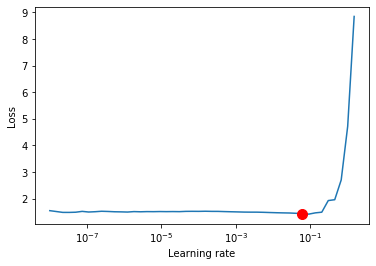

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


0.060981289463241585
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [68]:
lr_finder = trainer.tuner.lr_find(model,train_loader,val_loader,max_lr=5,num_training=50,mode='exponential',early_stop_threshold=4)

fig = lr_finder.plot(True,True)
print(lr_finder.suggestion())

args['lr'] = lr_finder.suggestion()
Net = M.Load_model(args['type'],args)
model = Net()
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,)

In [7]:
# args['lr'] = 8e-2
# Net = M.Load_model(args['type'],args)
# model = Net()
# trainer, wandb_logger = fc.return_trainer(path = path,
#                                           run_name = run_name,
#                                           args = args,)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Remember all accuracies are positive and defined to go towards 0 in the optimal case.
This model assumes Charge is at index 0 and position is the last three


In [7]:
wandb_logger.experiment.config.update(args)
# wandb_logger.watch(model)
# wandb_logger.experiment.log({f'lr finder, lr={lr_finder.suggestion()}': wandb.Image(fig)})

wandb: Currently logged in as: vinther901 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type       | Params
-----------------------------------------
0 | act       | SiLU       | 0     
1 | x_encoder | MLP        | 7.4 K 
2 | convs     | ModuleList | 17.2 K
3 | decoder   | MLP        | 41.8 K
-----------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)


Epoch 0, global step 585: Val Acc reached 2.19128 (best 2.19128), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\test_angle_m10_yn3x\test_angle_m10-epoch=0-Val Acc=2.191.ckpt" as top 1
C:\Users\jv97\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 1, step 924: Val Acc was not in top 1


1

In [9]:
trainer.save_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
print("potentially remember wandb.finish()")

potentially remember wandb.finish()


C:\Users\jv97\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [11]:
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')

This model assumes Charge is at index 0 and position is the last three


In [12]:
pred, truth = fc.return_reco_truth(model,val_loader)

Batch: 100%|███████████████████████████████| 1172/1172 [17:08<00:00,  1.10it/s]

In [102]:
# pd.Series(dataset.val().event_nos,name='event_no').to_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\val_event_nos.pkl')

0        105314908
1        114395327
2        117298442
3        102188838
4         30180837
           ...    
40652     51151307
40653     54156359
40654     75154484
40655     48105662
40656     78091584
Name: event_no, Length: 40657, dtype: int64

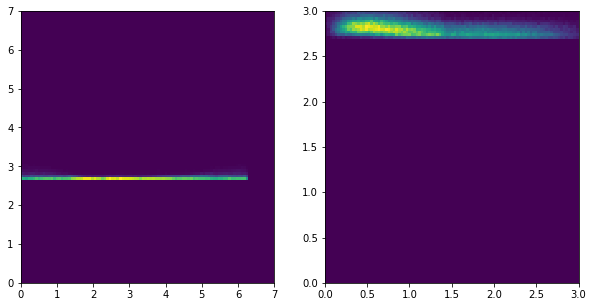

In [19]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(truth[:,0],pred[:,0]+3,bins=100,range=((0,7),(0,7)));
ax[1].hist2d(truth[:,1],pred[:,1]+3,bins=100,range=((0,3),(0,3)));

In [10]:
wandb.finish()

lr-Adam,0.01789
_runtime,2022
_timestamp,1616152425
_step,899
Train Loss,1.30021
Train Acc,1.90416
epoch,1
Val Acc,2.19128


lr-Adam,▁█
_runtime,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇██
Train Loss,████████▇▆▇▇▅▄▅▅▂▁
Train Acc,▇▇▆▇█▇▆▇▆▆█▇▆▆▆▅▅▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁███████
Val Acc,▁
